In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Training data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [132]:
test_no_bg = process_data.remove_background(scan_100206_long, mask_100206_long)

In [133]:
test_begin_0 = np.where(test_no_bg[:, 0] == 0)[0]

In [136]:
test_begin_0

array([ 46080,  52289,  58710,  61649,  65169,  75865,  77984,  82681,
        88184,  96165,  96248,  98616, 104386, 104471, 105834, 106935,
       112589, 112845, 112930, 115186, 115316, 121280, 121706, 124612,
       127409, 130165, 130591, 132693, 133084, 133597, 137541, 139400,
       139753, 141694, 141918, 142846, 148444, 148806, 149505, 149838,
       151134, 151227, 151272, 152002, 152206, 152349, 152407, 154601,
       156409, 158104, 158288, 158471, 159177, 159511, 160888, 160932,
       161452, 161721, 161983, 161984, 162113, 162132, 162210, 167928,
       168205, 168297, 169004, 169341, 171395, 171798, 171931, 171948,
       172006, 172027, 172164, 172422, 172512, 172608, 172704, 178028,
       178213, 179261, 181980, 182142, 182491, 182588, 182685, 188111,
       188564, 189253, 189586, 191392, 191682, 192585, 192681, 192778,
       198338, 199046, 199391, 199725, 201834, 202277, 202792, 205301,
       208912, 209605, 209942, 211902, 211903, 211904, 212326, 212401,
      

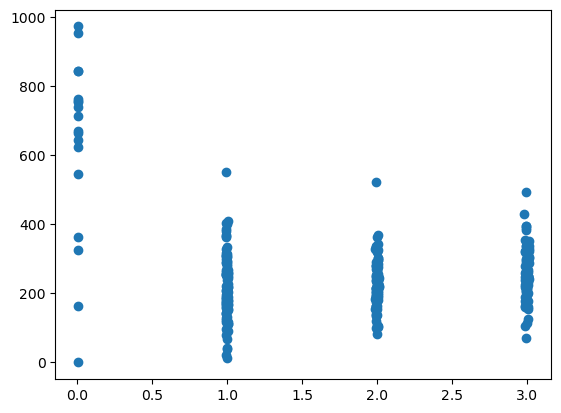

In [143]:
plt.plot(bvals_all, test_no_bg[930422,:], "o")

In [139]:
scan_100206_long[845451,:]

array([6704.40283203,  630.99127197,  211.24629211,  318.82394409,
        504.55914307,  386.30993652,  155.88322449,  526.62475586,
        516.15020752,  194.31488037,  611.7791748 ,  190.4210968 ,
        295.01586914,  593.07910156,  203.78581238,  384.11517334,
       6972.23583984,  425.44396973,  228.13539124,  277.37646484,
        345.67700195,  351.22134399,  300.18267822,  445.92837524,
        269.26135254,  308.71716309,  732.16296387,  377.91653442,
        229.0055542 ,  528.04382324,  261.96670532,  253.05070496,
       6568.37011719,  202.08164978,  553.2454834 ,  218.13262939,
        555.94897461,  278.75131226,  355.13546753,  266.76965332,
        206.87550354,  261.34887695,  244.15737915,  660.43737793,
        194.80184937,  469.1257019 ,  258.69174194,  293.92440796,
       7040.28076172,  547.21337891,  353.21115112,  339.99447632,
        260.35806274,  280.42892456,  289.72915649,  671.47375488,
        261.31918335,  388.38677979,  676.94488525,  295.99072

In [5]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [13]:
bvals_all = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [14]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all)

In [15]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [16]:
len(np.where(S0_100206 < 100)[0])

609

In [17]:
big_b_indices = np.where(bvals_all != 0.005)[0]

In [18]:
bvals = bvals_all[big_b_indices]

In [19]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices]

In [20]:
normalized_scan_100206_no_b5.shape

(935442, 270)

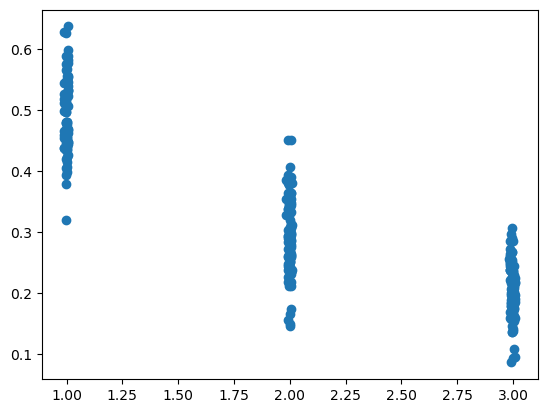

In [21]:
plt.plot(bvals, normalized_scan_100206_no_b5[1565,:], "o")

In [46]:
np.save("normalized_scan_100206_no_b5.npy",normalized_scan_100206_no_b5)

In [4]:
normalized_scan_100206_no_b5 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalised_data/normalized_scan_100206_no_b5.npy")

## Neural Network

In [22]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [23]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [24]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [25]:
n_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n = n_all[:,big_b_indices].T
print(n.shape)

b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

(270, 3)


In [26]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [54]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 50

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 121.81it/s]


Loss: 448.01214805897325
Average Loss: 0.06130434428831052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.42it/s]


Loss: 446.8648185399361
Average Loss: 0.06114734791186865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.95it/s]


Loss: 446.94926803093404
Average Loss: 0.06115890367144691
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:36<00:00, 75.81it/s]


Loss: 441.1520787139889
Average Loss: 0.060365637481388734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:28<00:00, 82.72it/s]


Loss: 433.9794767538551
Average Loss: 0.05938416485411263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.59it/s]


Loss: 436.6759292471688
Average Loss: 0.05975313755434713
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.49it/s]


Loss: 432.8763507157564
Average Loss: 0.05923321712038265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.15it/s]


Loss: 434.09201491624117
Average Loss: 0.05939956416478396
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.02it/s]


Loss: 435.2435096106492
Average Loss: 0.05955713048859458
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.48it/s]


Loss: 431.6699057808146
Average Loss: 0.05906813160657014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|▉                                                         | 122/7308 [00:03<00:56, 128.32it/s]

X_batch: 
torch.Size([128, 270])
tensor([[0.4551, 0.2281, 0.1631,  ..., 0.5672, 0.2644, 0.1707],
        [0.4843, 0.2894, 0.1741,  ..., 0.3891, 0.2596, 0.3009],
        [0.3669, 0.2320, 0.2060,  ..., 0.3733, 0.1521, 0.1699],
        ...,
        [0.5190, 0.2560, 0.2217,  ..., 0.4546, 0.2989, 0.1247],
        [0.1766, 0.1342, 0.1162,  ..., 0.1155, 0.0954, 0.1170],
        [0.4408, 0.2771, 0.1284,  ..., 0.4813, 0.2738, 0.2064]])
X_pred: 
torch.Size([128, 270])
tensor([[0.4862, 0.2568, 0.1796,  ..., 0.4846, 0.2722, 0.1706],
        [0.4590, 0.3454, 0.2336,  ..., 0.4351, 0.3282, 0.3064],
        [0.3895, 0.1870, 0.1393,  ..., 0.3877, 0.2040, 0.1350],
        ...,
        [0.4888, 0.2637, 0.1882,  ..., 0.4888, 0.2696, 0.1751],
        [0.1640, 0.0924, 0.0681,  ..., 0.1610, 0.0896, 0.0900],
        [0.4101, 0.2079, 0.1362,  ..., 0.4065, 0.2181, 0.1497]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.25it/s]


Loss: 432.91513478546403
Average Loss: 0.059238524190676524
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.03it/s]


Loss: 435.5808464467991
Average Loss: 0.05960329042785976
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.82it/s]


Loss: 431.548438842874
Average Loss: 0.059051510514897924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.17it/s]


Loss: 428.9198615127243
Average Loss: 0.05869182560382106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.22it/s]


Loss: 431.16411206522025
Average Loss: 0.05899892064384513
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.81it/s]


Loss: 441.4552482753061
Average Loss: 0.060407122095690484
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.80it/s]


Loss: 450.7584351962432
Average Loss: 0.06168013617901522
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.06it/s]


Loss: 544.2206859602593
Average Loss: 0.0744691688506102
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 4


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:29<00:00, 81.35it/s]


Loss: 516.8774502510205
Average Loss: 0.07072762045033121
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 100.10it/s]


Loss: 446.7546149394475
Average Loss: 0.06113226805411159
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.67it/s]


Loss: 443.71850673365407
Average Loss: 0.06071681810805338
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.71it/s]


Loss: 439.46499183098786
Average Loss: 0.06013478268075915
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.26it/s]


Loss: 497.01514677749947
Average Loss: 0.06800973546490141
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 9


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:26<00:00, 84.83it/s]


Loss: 484.7847250108607
Average Loss: 0.06633616926804334
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 10


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.12it/s]


Loss: 493.2629824106116
Average Loss: 0.06749630301185161
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 11


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.48it/s]


Loss: 476.7756693260744
Average Loss: 0.06524023937138403
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 12


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.41it/s]


Loss: 502.3716746624559
Average Loss: 0.06874270315578214
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 13


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.47it/s]


Loss: 541.5734634757973
Average Loss: 0.0741069326047889
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 14


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 101.22it/s]


Loss: 659.7989351595752
Average Loss: 0.09028447388609404
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 15


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 101.03it/s]


Loss: 1032.4012698158622
Average Loss: 0.14127001502680106
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 16


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.64it/s]


Loss: 1228.236178562045
Average Loss: 0.16806734791489397
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 17


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 94.91it/s]


Loss: 1183.962078154087
Average Loss: 0.16200904189300588
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 18


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 93.83it/s]


Loss: 1247.447688959539
Average Loss: 0.1706961807552735
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 19


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.25it/s]


Loss: 1242.702062882483
Average Loss: 0.17004680663416571
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 20


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.83it/s]


Loss: 1198.9707510918379
Average Loss: 0.16406277382209056
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 21


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.94it/s]


Loss: 1162.6708816252649
Average Loss: 0.15909563240630334
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 22


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.58it/s]


Loss: 1200.942805275321
Average Loss: 0.16433262250620156
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 23


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.62it/s]


Loss: 1182.0761939361691
Average Loss: 0.16175098439192243
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 24


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.52it/s]


Loss: 1154.99251748994
Average Loss: 0.15804495313217568
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 25


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.14it/s]


Loss: 878.0567869134247
Average Loss: 0.12015008031108713
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 26


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:37<00:00, 75.00it/s]


Loss: 920.5416355580091
Average Loss: 0.12596355166365752
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 27


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:41<00:00, 71.88it/s]


Loss: 1174.3171764239669
Average Loss: 0.16068926880459317
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 28


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 91.97it/s]


Loss: 1179.721061423421
Average Loss: 0.1614287166698715
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 29


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.38it/s]


Loss: 1106.4239524565637
Average Loss: 0.15139900827265512
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 30


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.43it/s]


Loss: 1136.5223863013089
Average Loss: 0.1555175679120565
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 31


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:33<00:00, 78.40it/s]


Loss: 1140.8983709029853
Average Loss: 0.15611636164518136
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 32


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 92.56it/s]


Loss: 1191.4717822372913
Average Loss: 0.16303664234226756
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 33


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 94.42it/s]


Loss: 1182.971711076796
Average Loss: 0.16187352368319596
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 34


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.90it/s]


Loss: 1005.2480642572045
Average Loss: 0.13755446965752663
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 35


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:24<00:00, 86.37it/s]


Loss: 885.7459668517113
Average Loss: 0.12120223958014659
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 36


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 78.78it/s]


Loss: 1143.7440680079162
Average Loss: 0.15650575643239137
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 37


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.52it/s]


Loss: 1137.161095943302
Average Loss: 0.15560496660417378
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 38


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.99it/s]


Loss: 901.8631080761552
Average Loss: 0.12340765025672622
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 39


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 92.50it/s]


Loss: 922.6107555069029
Average Loss: 0.12624668247220894
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 40


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.11it/s]


Loss: 801.2651927173138
Average Loss: 0.10964219933187107
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 41


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 97.99it/s]


Loss: 908.6880677938461
Average Loss: 0.12434155279061934
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 42


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:28<00:00, 82.37it/s]


Loss: 1014.2531293258071
Average Loss: 0.138786689836591
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 43


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:25<00:00, 85.79it/s]


Loss: 1123.0929126478732
Average Loss: 0.1536799278390631
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 44


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.08it/s]


Loss: 1170.053036544472
Average Loss: 0.16010577949431745
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 45


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.79it/s]


Loss: 1034.1398403309286
Average Loss: 0.14150791465940457
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 46


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 92.94it/s]


Loss: 1091.6751981936395
Average Loss: 0.14938084266470164
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 47


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:29<00:00, 81.65it/s]


Loss: 1170.805239893496
Average Loss: 0.16020870825034156
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 48


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:31<00:00, 79.97it/s]


Loss: 1232.074494883418
Average Loss: 0.16859256908640094
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 49


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:45<00:00, 69.58it/s]

Loss: 1249.5882544443011
Average Loss: 0.17098908790972922
Done, best loss: 428.9198615127243
Done


<All keys matched successfully>

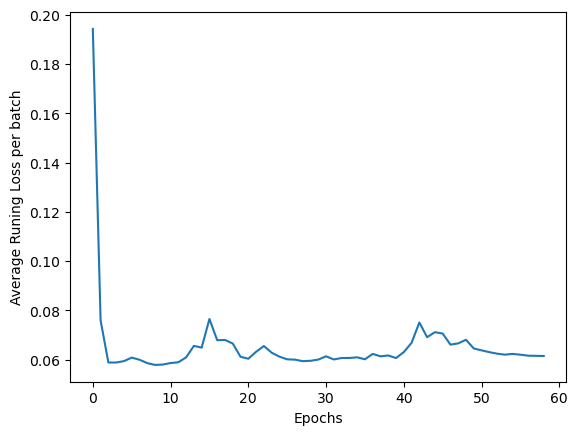

In [28]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

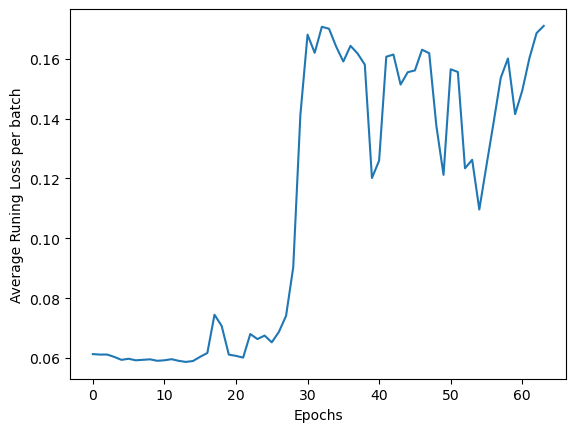

In [55]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [38]:
torch.save(final_model, 'model_100206_norm_01_Feb_58e_better_range.pt')

In [56]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [57]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)))

In [31]:
lambda_iso_pred_train.shape

torch.Size([935442, 1])

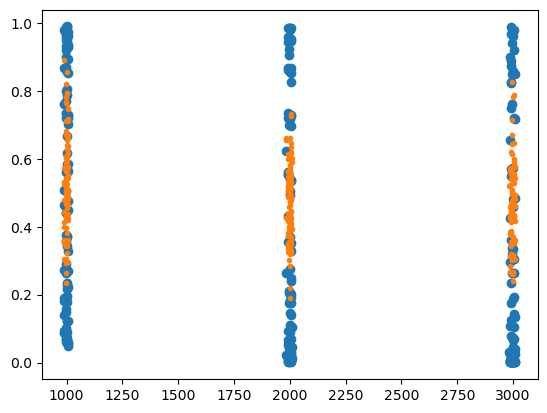

In [61]:
plt.plot(bvals*1e03, X_pred_train[0,:].detach().numpy(),  "o")
plt.plot(bvals*1e03,normalized_scan_100206_no_b5[0,:], ".")

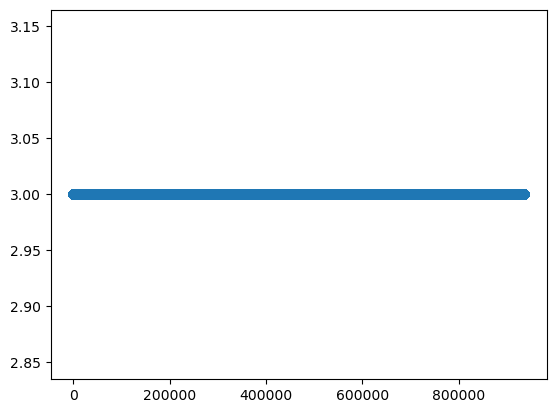

In [62]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

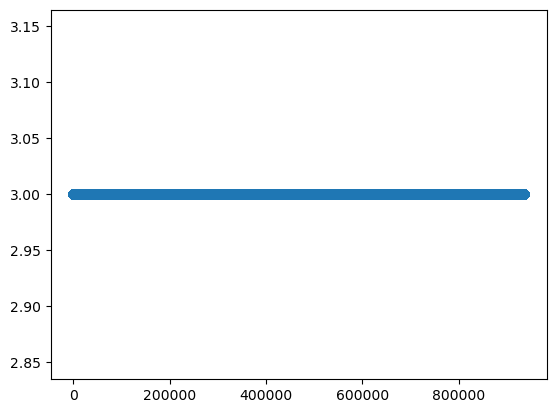

In [63]:
plt.plot(lambda_iso_pred_train.detach().numpy(), 'o')

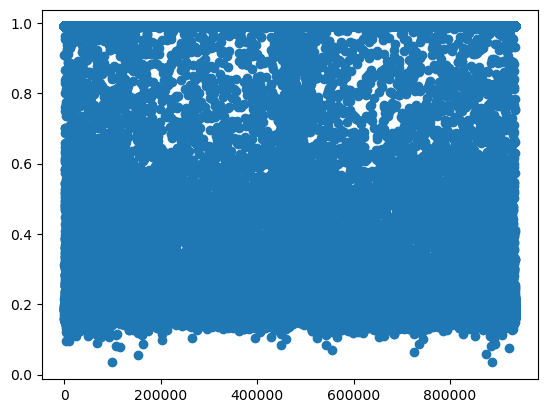

In [64]:
plt.plot(volume_0_pred_train.detach().numpy(), 'o')

In [39]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [40]:
lambda_par_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_par_pred_train, (145, 174, 145))

In [41]:
lambda_iso_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_iso_pred_train, (145, 174, 145))

In [42]:
volume_0_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_0_pred_train, (145, 174, 145))

In [43]:
volume_1_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_1_pred_train, (145, 174, 145))

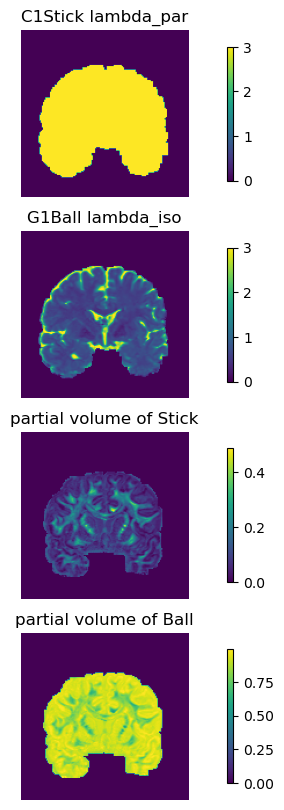

In [44]:
fig, axs = plt.subplots(4, 1, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[1].set_title("G1Ball lambda_iso")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[2].set_title("partial volume of Stick")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[3].set_title("partial volume of Ball")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

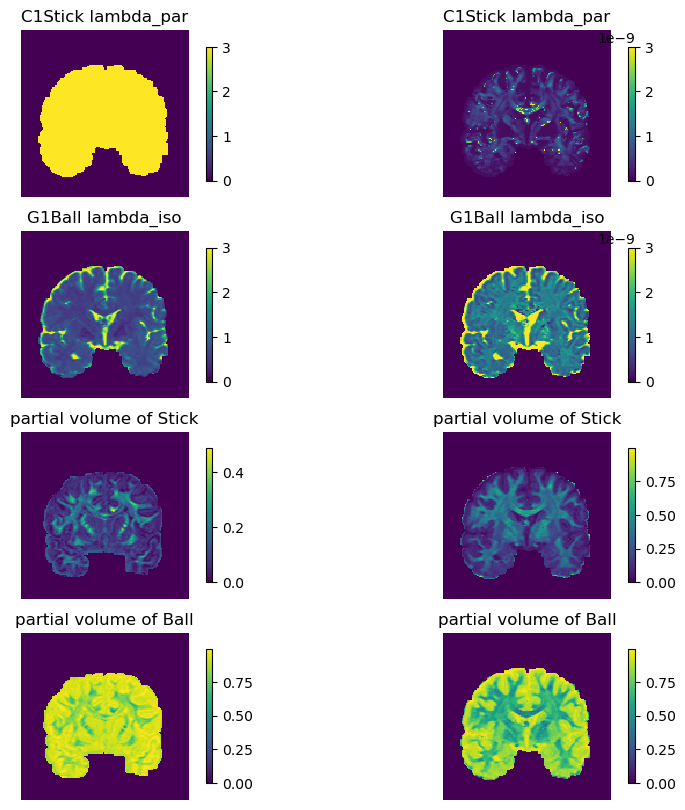

In [53]:
fig, axs = plt.subplots(4, 2, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(fitted_parameters.get("C1Stick_1_lambda_par").squeeze().T, origin='lower', interpolation='nearest')
axs[1].set_title("C1Stick lambda_par")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[2].set_title("G1Ball lambda_iso")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(fitted_parameters.get("G1Ball_1_lambda_iso").squeeze().T, origin='lower', interpolation='nearest')
axs[3].set_title("G1Ball lambda_iso")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

cf = axs[4].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[4].set_title("partial volume of Stick")
axs[4].set_axis_off()
fig.colorbar(cf, ax=axs[4], shrink=0.8)
cf = axs[5].imshow(fitted_parameters.get("partial_volume_0").squeeze().T, origin='lower', interpolation='nearest')
axs[5].set_title("partial volume of Stick")
axs[5].set_axis_off()
fig.colorbar(cf, ax=axs[5], shrink=0.8)

cf = axs[6].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[6].set_title("partial volume of Ball")
axs[6].set_axis_off()
fig.colorbar(cf, ax=axs[6], shrink=0.8)
cf = axs[7].imshow(fitted_parameters.get("partial_volume_1").squeeze().T, origin='lower', interpolation='nearest')
axs[7].set_title("partial volume of Ball")
axs[7].set_axis_off()
fig.colorbar(cf, ax=axs[7], shrink=0.8)

In [46]:
scan_100206_slice = scan_100206[:, 100, :, :]

In [47]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [48]:
scheme_hcp_100206_slice = get_acquisition_scheme(bvals_all*1e9, n_all.T)

In [49]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [50]:
BAS_fit_hcp_100206_slice = BAS_mod.fit(scheme_hcp_100206_slice, scan_100206_slice, mask_100206[:,100,:])

Setup brute2fine optimizer in 0.2092270851135254 seconds
Fitting of 8433 voxels complete in 198.88885593414307 seconds.
Average of 0.023584591003693 seconds per voxel.


In [52]:
fitted_parameters = BAS_fit_hcp_100206_slice.fitted_parameters

In [111]:
fitted_parameters.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])